# 타이타닉 생존자 예측

- Survived: 생존여부 (0=사망 or 1=생존)
- Pclass: 티켓등급 (1=1등석, 2=2등석, 3=3등석)
- Sex: 성별
- Age: 연령
- SibSp: 동승 중인 형제나 배우자 수
- Parch: 동승 중인 부모나 자녀의 수
- Ticket: 티켓 번호
- Fare: 티켓 요금
- Cabin: 방 번호
- Embarked: 승선한 항구 이름 (C, Q, S)

# 2주차

In [65]:
import lightgbm as lgb

### 홀드 아웃

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [95]:
#20%를 검증 데이터로 분할
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size = 0.2)

In [96]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,honorific,family_num,alone
773,3,1,32.252151,0,0,7.2250,0,2,0,1.0
347,3,0,36.994118,1,0,16.1000,2,3,1,0.0
19,3,0,36.994118,0,0,7.2250,0,3,0,1.0
863,3,0,21.774238,8,2,69.5500,2,1,10,0.0
104,3,1,37.000000,2,0,7.9250,2,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...
67,3,1,19.000000,0,0,8.1583,2,2,0,1.0
460,1,1,48.000000,0,0,26.5500,2,2,0,1.0
129,3,1,45.000000,0,0,6.9750,2,2,0,1.0
72,2,1,21.000000,0,0,73.5000,2,2,0,1.0


In [97]:
y_train

773    0
347    1
19     1
863    0
104    0
      ..
67     0
460    1
129    0
72     0
399    1
Name: Survived, Length: 712, dtype: int64

In [151]:
#분류에 유의미한 특성을 지정
categories = ['Embarked','Pclass','Sex','honorific','alone'] 

#학습용 특성 데이터와 타겟 데이터, 매개변수를 통해 범주형의 특성을 지정
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)

#검증용 특성 데이터와 타겟 데이터, 범주형 특성 지정
#reference: 학습 데이터셋을 참조. 학습 시 동일한 범주형 특성 처리 적용이 가능
 #보통 ligjtGBM은 학습 데이터셋을 먼저 만들고, 이를 참조하여 검증 데이터셋을 만듦.
 #같은 방식으로 저처리가 되기 때문.
lgb_eval = lgb.Dataset(X_valid, y_valid,  categorical_feature=categories, reference=lgb_train)

In [152]:
#하이퍼파라미터 - 생존과 사망에 대해서만 분류하므로, binary로 설정
lgbm_params = {
    "objective":"binary",
    "random_seed":1234
}

In [153]:
#머신러닝 학습
model_lgb = lgb.train(lgbm_params,
                      lgb_train,
                      valid_sets = lgb_eval,
                      num_boost_round = 100, #몇 번의 트리가 추가로 학습될지 결정
                      early_stopping_rounds=20, #성능 향상x 시, 조기 종료를 위한 설정. 
                      verbose_eval=10) #10번째 트리마다 출력

Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.462714
[20]	valid_0's binary_logloss: 0.428688
[30]	valid_0's binary_logloss: 0.422894
[40]	valid_0's binary_logloss: 0.426613
[50]	valid_0's binary_logloss: 0.437656
Early stopping, best iteration is:
[33]	valid_0's binary_logloss: 0.422436


C:\Users\onlyo\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


* 데이터셋에서 손실이 가장 작은 경우가 0.422xxx
* 손실이 작을 수록 모델의 예측이 더 좋다는 것을 의미(모델의 예측값과 실제 레이블 간의 차이를 계산)

In [154]:
#각 변수의 중요도
model_lgb.feature_importance()

array([ 51,  30, 322,  19,  10, 332,  42,  10,  28,   4])

<Axes: >

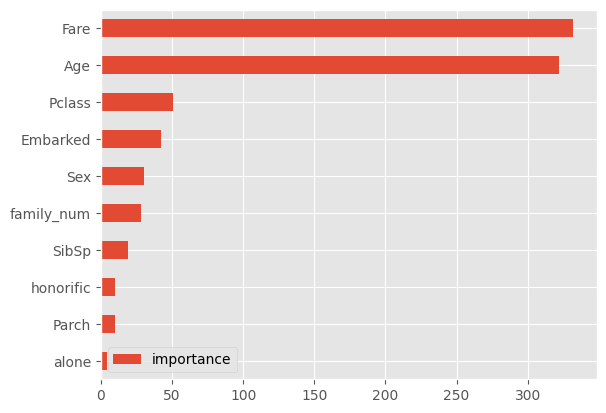

In [155]:
importance = pd.DataFrame(model_lgb.feature_importance(), index = X_train.columns, columns = ['importance']).sort_values(by = "importance", ascending = True)
importance.plot.barh()

### 예측 정확도 확인

In [156]:
#검증 데이터에 적용
#num_iteration: 사용할 트리의 개수 지정, 최적의 트리 개수를 입력
y_pred = model_lgb.predict(X_valid, num_iteration = model_lgb.best_iteration)

* 정확도(accurancy): 전체 데이터 중 '예측 결과=실제 값'인 데이터 비율
>(TN+TP)/(TN+FP+FN+TP)
* 정밀도(precision): 예측을 P로 한 대상 중 예측 결과와 실제 값이 P인 데이터의 비율 
>TP/(FP+TP)
* 재현율(recall): 실제 P인 대상 중 예측 결과와 실제 값이 P인 데이터의 비율 
> TP/(FN+TP)

In [157]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [158]:
confusion_matrix(y_valid, np.round(y_pred)) #오차행렬

array([[102,  15],
       [ 15,  47]], dtype=int64)

In [159]:
accuracy_score(y_valid, np.round(y_pred)) #정확도

0.8324022346368715

In [160]:
precision_score(y_valid, np.round(y_pred)) #정밀도

0.7580645161290323

In [161]:
recall_score(y_valid, np.round(y_pred)) #재현율

0.7580645161290323

In [162]:
#하이퍼파라미터 변경
lgbm_params = {
    "objective":"binary",
    "max_bin":331, #범용성 증가
    "num_leaves":20, #잎 노드 증가로 모델의 복잡성 증가
    "min_data_in_leaf":57, #잎 노드에 필요한 최소 데이터 증가로 트리 일반화
    "andom_seed":1234
}

In [163]:
#재실행
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categories, reference=lgb_train)


In [164]:
model_lgb = lgb.train(lgbm_params, lgb_train, 
                      valid_sets=lgb_eval, 
                      num_boost_round=100,
                      early_stopping_rounds=20,
                      verbose_eval=10)

Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.48088
[20]	valid_0's binary_logloss: 0.447188
[30]	valid_0's binary_logloss: 0.448972
[40]	valid_0's binary_logloss: 0.453134
Early stopping, best iteration is:
[27]	valid_0's binary_logloss: 0.442573


C:\Users\onlyo\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [165]:
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

In [166]:
confusion_matrix(y_valid, np.round(y_pred)) 

array([[103,  14],
       [ 17,  45]], dtype=int64)

In [167]:
accuracy_score(y_valid, np.round(y_pred))

0.8268156424581006

### 교차 검증

In [168]:
folds = 3 #3개로 데이터 분할
kf = KFold(n_splits = folds)

In [169]:
models = [] #3개의 모델들이 들어갈 빈 리스트

for train_index, val_index in kf.split(train_X): #각각 3개의 학습,테스트 데이터 
    X_train = train_X.iloc[train_index] #학습데이터의 설명(독립) 변수 - 학습데이터의 인덱스에 해당하는 부분 추출
    X_valid = train_X.iloc[val_index] #검증데이터의 설명 변수
    y_train = train_Y.iloc[train_index] #학습데이터의 목표(종속) 변수
    y_valid = train_Y.iloc[val_index] #검증데이터의 목표 변수
        
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
    lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )
    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    print(accuracy_score(y_valid, np.round(y_pred)))
    
    models.append(model_lgb)

C:\Users\onlyo\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\onlyo\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.503031
[20]	valid_0's binary_logloss: 0.465863
[30]	valid_0's binary_logloss: 0.454056
[40]	valid_0's binary_logloss: 0.451228
[50]	valid_0's binary_logloss: 0.44724
[60]	valid_0's binary_logloss: 0.447342
[70]	valid_0's binary_logloss: 0.450126
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.445648
0.8249158249158249
Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss: 0.482264
[20]	valid_0's binary_logloss: 0.440853
[30]	valid_0's binary_logloss: 0.435016
[40]	valid_0's binary_logloss: 0.433286
[50]	valid_0's binary_logloss: 0.432128
[60]	valid_0's binary_logloss: 0.430387
[70]	valid_0's binary_logloss: 0.431241
[80]	valid_0's binary_logloss: 0.438053
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.429561
0.8181818181818182
Training until validation scores don't improve for 20 rounds
[10]	valid_0's binary_logloss:

C:\Users\onlyo\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


* 총 3개의 정확도를 가진 모델 생성
* 최종 정확도는 모델들의 정확도의 평균을 구함

In [173]:
#예측 결과 산출
preds = []

for model in models:
    pred = model.predict(test_X) #테스트 데이터의 결과를 예측
    preds.append(pred) #예측값을 preds에 저장

In [183]:
# 결과 평균 구하기
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis = 0) #예측 값을 하나씩 더해 평균을 내므로 행 기준으로

In [178]:
pred_int = (preds_mean>0.5).astype(int) #평균이므로 int형, 0.5를 기준으로 사망과 생존으로 예측

In [181]:
submission['Survived'] = pred_int

In [182]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
